In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [2]:
seed = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

lr = 0.001
beta = 3

epochs = 30
log_interval = 2

no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Num_GPU :', torch.cuda.device_count())
batch_size = 128 * torch.cuda.device_count()
test_batch_size = 128 * torch.cuda.device_count()

torch.manual_seed(seed)

kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

Num_GPU : 2


# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*512, 256)
        self.fc2 = nn.Linear(256,int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*256)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(256, 256, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(128)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(256, 64, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(128)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(128, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(128, 1, 5, 2, 2, 1)
        
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(IMG_HEIGHT/16),int(IMG_WIDTH/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        rec = self.conv15(d3_uni) #3x128x128
        mask = self.conv16(d3_uni) #1x128x128
        
        return torch.sigmoid(rec), torch.sigmoid(mask)

# Preprocess

In [4]:
train_paths = glob('C:/Users/IVCL/Desktop/duck/many_circle/train/image/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/duck/real/val/image/*.png')
len(train_paths), len(test_paths), len(val_paths)

(20000, 253, 1000)

In [5]:
def get_label(path):
    rec_path = path[:-20]+'rec/'+path[-14:]
    rec = Image.open(rec_path).convert("RGB")
    rec = np.array(rec)
    #label = np.where(label>0,1.0,0)
    rec = torch.from_numpy(rec/255)
    rec = rec.permute(2,0,1)
    
    mask_path = path[:-20]+'label2/'+path[-14:]
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = np.where(mask>0,1.0,0)
    mask = torch.from_numpy(mask)
    mask = mask.unsqueeze_(0)
    
    return rec.float(), mask.float()

In [6]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # Read Image
        image = Image.open(path).convert("RGB")
        
        #Get Label
        rec, mask = get_label(path)
        
        if self.transform:
            image = self.transform(image)

        return image, rec, mask

In [7]:
train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                #transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

In [8]:
for i, (data, rec, mask) in enumerate(train_loader):
    if i == 0:
        print(data[0].shape, rec[0].shape, mask[0].shape)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


# Optimization

In [9]:
model = Net()
model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]           4,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         409,728
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         LeakyReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         409,728
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]         819,328
      BatchNorm2d-14          [-1, 128,

# Visualization

In [11]:
def visualization(model, test_path, rec_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    rec_result, mask_result = model(image)
    rec_result, mask_result = rec_result.permute(0,2,3,1).to('cpu').detach().numpy(), mask_result.to('cpu').detach().numpy()
    mask_result = np.where(mask_result[0,:,:,:]>=0.5, 1.0, 0)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    mask_image = plt.imread(mask_path)
    plt.figure(figsize=(20,20))
    display_list = [test_image, rec_image, rec_result[0,:,:,:], mask_image, mask_result[0,:,:]]
    title = ['Input Image', 'Ground Truth(Rec)', 'Predicted(Rec)','Ground Truth(Mask)', 'Predicted(Mask)']
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

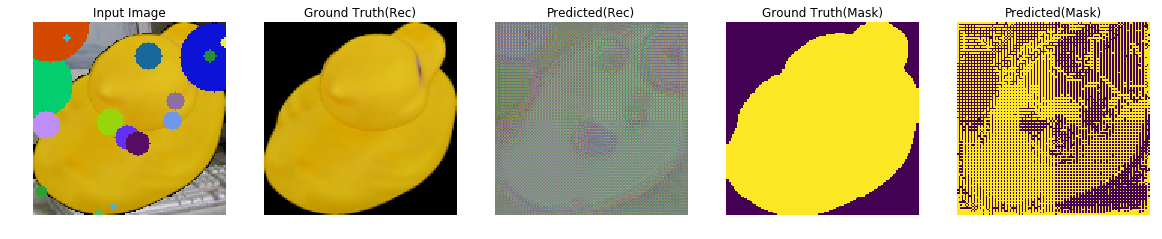

In [12]:
test_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/label2/duck_00001.png'
visualization(model, test_path, rec_path, mask_path)

# Training

In [13]:
checkpoint_path = './checkpoints_tc120_lm_many_circle_occlusionX_reconstruction2_beta3_stride'

In [14]:
loss_list = []
val_loss_list = []
rec_loss_list = []
val_rec_loss_list = []
mask_loss_list = []
val_mask_loss_list = []

for epoch in range(1, epochs + 1):
    # Train Mode
    model.to(device).train()

    train_loss_sum = 0
    val_loss_sum = 0 
    train_rec_loss_sum = 0
    val_rec_loss_sum = 0 
    train_mask_loss_sum = 0
    val_mask_loss_sum = 0     
    
    cut_num = 10 # 1 epoch당 train할 batch_idx (256 * 10 = 2560)
    
    for batch_idx, (data, rec_target, mask_target) in enumerate(train_loader):
        
        data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
        optimizer.zero_grad()
        rec_output, mask_output = model(data)
        
        mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
        
        multiply = torch.mul(rec_output, mask_target)
        multiply2 = torch.mul(rec_output, mask_target_reverse)
        
        rec_target2 = torch.mul(rec_target, mask_target_reverse)
        
        rec_loss1 = F.mse_loss(multiply, rec_target)
        rec_loss2 = F.mse_loss(multiply2, rec_target2)
        mask_loss = F.binary_cross_entropy(mask_output, mask_target)
        
        rec_loss = rec_loss1*beta + rec_loss2
        
        loss = rec_loss + mask_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss_sum = train_loss_sum + loss.item()
        train_rec_loss_sum = train_rec_loss_sum + rec_loss.item()
        train_mask_loss_sum = train_mask_loss_sum + mask_loss.item()
                
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}'.format(
                epoch, batch_idx * len(data), cut_num * batch_size,
                100. * batch_idx * len(data) / (cut_num * batch_size), train_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_rec_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_mask_loss_sum / ((batch_idx + 1e-7) * len(data))))
            
        if batch_idx == cut_num:
            break
    
    # Test mode
    model.eval()
    val_loss = 0
    val_rec_loss = 0
    val_mask_loss = 0
    
    with torch.no_grad():
        for data, rec_target, mask_target in val_loader:
            data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
            rec_output, mask_output = model(data)
            
            mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
            
            multiply = torch.mul(rec_output, mask_target)
            multiply2 = torch.mul(rec_output, mask_target_reverse)
            
            rec_target2 = torch.mul(rec_target, mask_target_reverse)
            
            rec_loss1 = F.mse_loss(multiply, rec_target)
            rec_loss2 = F.mse_loss(multiply2, rec_target2)
            
            val_rec_loss = rec_loss1*beta + rec_loss2
            val_mask_loss = F.binary_cross_entropy(mask_output, mask_target)
            
            val_loss = val_rec_loss + val_mask_loss
            
            val_loss_sum = val_loss_sum + val_loss.item()
            val_rec_loss_sum = val_rec_loss_sum + val_rec_loss.item()
            val_mask_loss_sum = val_mask_loss_sum + val_mask_loss.item()
            
    loss_list.append(train_loss_sum / len(train_loader.dataset))
    val_loss_list.append(val_loss_sum / len(val_loader.dataset))
    rec_loss_list.append(train_rec_loss_sum / len(train_loader.dataset))
    val_rec_loss_list.append(val_rec_loss_sum / len(val_loader.dataset)) 
    mask_loss_list.append(train_mask_loss_sum / len(train_loader.dataset))
    val_mask_loss_list.append(val_mask_loss_sum / len(val_loader.dataset)) 
    
    print('\nValidation set: Average Loss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}'.format(
        val_loss_sum / len(val_loader.dataset), val_rec_loss_sum / len(val_loader.dataset),
        val_mask_loss_sum / len(val_loader.dataset)))
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/epoch-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc120\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Train Epoch: 1 [0/2560 (0%)]	Loss: 63508.809544	Rec_Loss:  18015.111564	Mask_Loss:  45493.696816
Train Epoch: 1 [512/2560 (20%)]	Loss: 0.007551	Rec_Loss:  0.001941	Mask_Loss:  0.005610
Train Epoch: 1 [1024/2560 (40%)]	Loss: 0.004948	Rec_Loss:  0.001313	Mask_Loss:  0.003634
Train Epoch: 1 [1536/2560 (60%)]	Loss: 0.003878	Rec_Loss:  0.001057	Mask_Loss:  0.002821
Train Epoch: 1 [2048/2560 (80%)]	Loss: 0.003275	Rec_Loss:  0.000904	Mask_Loss:  0.002371
Train Epoch: 1 [2560/2560 (100%)]	Loss: 0.002883	Rec_Loss:  0.000798	Mask_Loss:  0.002085

Validation set: Average Loss: 0.008331	Rec_Loss:  0.001218	Mask_Loss:  0.007113
Train Epoch: 2 [0/2560 (0%)]	Loss: 12387.157185	Rec_Loss:  3450.022487	Mask_Loss:  8937.134407
Train Epoch: 2 [512/2560 (20%)]	Loss: 0.001739	Rec_Loss:  0.000484	Mask_Loss:  0.001256
Train Epoch: 2 [1024/2560 (40%)]	Loss: 0.001377	Rec_Loss:  0.000383	Mask_Loss:  0.000995
Train Epoch: 2 [1536/2560 (60%)]	Loss: 0.001248	Rec_Loss:  0.000347	Mask_Loss:  0.000901
Train Epoch: 2 [

Train Epoch: 27 [512/2560 (20%)]	Loss: 0.000169	Rec_Loss:  0.000048	Mask_Loss:  0.000121
Train Epoch: 27 [1024/2560 (40%)]	Loss: 0.000143	Rec_Loss:  0.000040	Mask_Loss:  0.000102
Train Epoch: 27 [1536/2560 (60%)]	Loss: 0.000133	Rec_Loss:  0.000038	Mask_Loss:  0.000095
Train Epoch: 27 [2048/2560 (80%)]	Loss: 0.000129	Rec_Loss:  0.000037	Mask_Loss:  0.000092
Train Epoch: 27 [2560/2560 (100%)]	Loss: 0.000126	Rec_Loss:  0.000036	Mask_Loss:  0.000090

Validation set: Average Loss: 0.001748	Rec_Loss:  0.000207	Mask_Loss:  0.001541
Train Epoch: 28 [0/2560 (0%)]	Loss: 1323.959586	Rec_Loss:  365.648739	Mask_Loss:  958.310848
Train Epoch: 28 [512/2560 (20%)]	Loss: 0.000177	Rec_Loss:  0.000051	Mask_Loss:  0.000126
Train Epoch: 28 [1024/2560 (40%)]	Loss: 0.000144	Rec_Loss:  0.000042	Mask_Loss:  0.000102
Train Epoch: 28 [1536/2560 (60%)]	Loss: 0.000137	Rec_Loss:  0.000039	Mask_Loss:  0.000098
Train Epoch: 28 [2048/2560 (80%)]	Loss: 0.000131	Rec_Loss:  0.000037	Mask_Loss:  0.000094
Train Epoch: 28 [

# Loss Curve

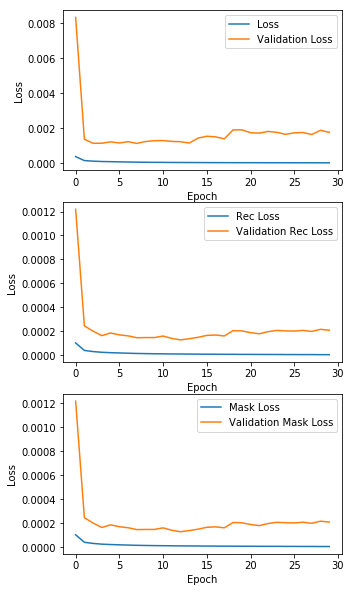

In [15]:
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rec_loss_list, label='Rec Loss')
plt.plot(val_rec_loss_list, label='Validation Rec Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rec_loss_list, label='Mask Loss')
plt.plot(val_rec_loss_list, label='Validation Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [16]:
weight_dict = torch.load(checkpoint_path+'/epoch-10.pt')

In [17]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

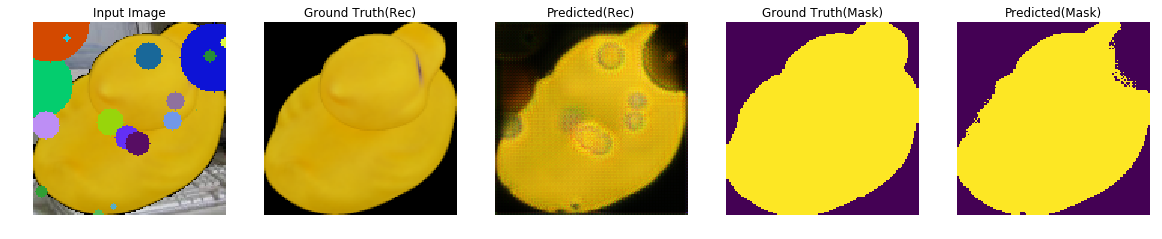

In [18]:
test_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/many_circle/train/label2/duck_00001.png'

visualization(model, test_path, rec_path, mask_path)

In [ ]:
i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(model, path, rec_path, mask_path)

In [20]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

In [21]:
test_prec = 0
test_rec = 0
num_test = 0
for batch_idx, (data, rec_target, mask_target) in enumerate(test_loader):
    data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
    rec_output, mask_output = model(data)
    print(mask_output.shape)
    test_prec += precision(mask_target, mask_output)
    test_rec += recall(mask_target, mask_output)
    num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test)

torch.Size([253, 1, 128, 128])
test_precision : 96.2638151038186 	test_recall : 89.23906870154302
